In [1]:
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import re
import random
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from operator import itemgetter

from sklearn import svm
from sklearn.model_selection import GridSearchCV

reading data and preparing them

In [3]:
# since python os list dir is not compaible with alphabetical order
# sort def used to set compatibility with that
# in other words it is to set file order compatible with dataset
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

# read all labels in one list, either bulding or explosion, even both
Y = []
# get all file in bulding directory to find name fo annotations files
keyF = os.listdir(r"project-data\annotations\building")
for i in keyF:
    # join name and directory to reach each file in that directory
    pathBuilding = os.path.join("project-data\\annotations\\building\\", i)
    pathExplosion = os.path.join("project-data\\annotations\\explosion_fire\\", i)
    # load annotations text file for both bulding and explosions as numpy array
    tempBuilding = np.loadtxt(pathBuilding, dtype = str)
    tempExplosion = np.loadtxt(pathExplosion, dtype = str)
    for i in range(len(tempBuilding)):
        if int(tempBuilding[i, 0]) == 1 and int(tempExplosion[i, 0]) == 1:
            # if both explosion and bulding is in image label image as 3
            Y.append(3)
        elif int(tempBuilding[i, 0]) == 0 and int(tempExplosion[i, 0]) == 1:
            # if only explosion is in image label image as 2
            Y.append(2)
        elif int(tempBuilding[i, 0]) == 1 and int(tempExplosion[i, 0]) == 0:
            # if only bulding is in image label image as 1
            Y.append(1)
        else:
            # id niether bulding or explosion not in image label it 0
            Y.append(0)

# load all image data to one list as an grayscale not 3dimensional array
# steps to reach fiel same as pervious
X = []
rgb_weights = [0.2989, 0.5870, 0.1140]
# witghs for transforming RGB image to 1 dimesion array
keyF = os.listdir(r"project-data\keyframes")
for i in keyF:
    pathFrames = os.path.join("project-data\\keyframes\\", i)
    pictures = sorted_alphanumeric(os.listdir(pathFrames))
    for j in pictures:
        # avoid junk files in directory
        if j != 'Thumbs.db':
            # read, transfrom and add array to main list
            img = mpimg.imread(os.path.join(pathFrames, j))
            grayscale_image = np.dot(img[...,:3], rgb_weights)
            X.append(grayscale_image)
        

In [4]:
# all dataset is divided in two fold as train and test data set
# for the sake of cross validation, together random shuffle wil be used
tempBld = list(zip(X, Y))
random.shuffle(tempBld)
X, Y = zip(*tempBld)
X_train, X_test = X[:][:int(len(X) * 0.75)], X[:][int(len(X) * 0.75):]
Y_train, Y_test = Y[:int(len(Y) * 0.75)], Y[int(len(Y) * 0.75):]


In [5]:
# define evaluate function to calculate preccesion of each classifier
def evaluate(y_true, y_pred):
    return (sum(x == y for x, y in zip(y_true, y_pred)) / len(y_true)) * 100

# Define knn algorithm and use it on image dataset

In [13]:
# Following function uses eucleadan distance to calculate liklehood
# inputs are k and X and correct corresponing answers
def predict(X_train, Y_train, X_test, K = 2):
    predictions = []
    for i in range(len(X_test)):
        # calculate distance
        dist = np.array([np.sqrt(np.sum((X_test[i] - x_t) ** 2)) for x_t in X_train])
        # sort distance till k
        dist_sorted = dist.argsort()[:K]
        neigh_count = {}
        for idx in dist_sorted:
            # for each k distance count neighbordhoods
            if Y_train[idx] in neigh_count:
                neigh_count[Y_train[idx]] += 1
            else:
                neigh_count[Y_train[idx]] = 1
        sorted_neigh_count = sorted(neigh_count.items(), key = itemgetter(1), reverse = True)
        predictions.append(sorted_neigh_count[0][0]) 
    return predictions

K = 1; Precision for KNN prediction: 71.57534246575342

--- 441.0444266796112 seconds to run KNN with K reach to 1. ---

K = 4; Precision for KNN prediction: 76.71232876712328

--- 865.8653597831726 seconds to run KNN with K reach to 4. ---

K = 7; Precision for KNN prediction: 79.7945205479452

--- 1389.7816932201385 seconds to run KNN with K reach to 7. ---

K = 10; Precision for KNN prediction: 80.82191780821918

--- 1910.2586417198181 seconds to run KNN with K reach to 10. ---

K = 20; Precision for KNN prediction: 80.70776255707763

--- 2472.411285877228 seconds to run KNN with K reach to 20. ---


--- 2472.4122817516327 seconds to run KNN algorith. ---



No handles with labels found to put in legend.


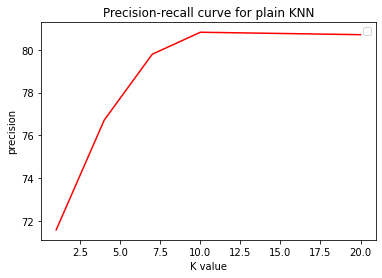

In [5]:
start_time = time.time()
kVals = [1, 4, 7, 10, 20]
accKNN = []
for k in kVals:
    # fet knn result for Test images
    y_pred_knn = predict(X_train, Y_train, X_test, k)
    # evaluate the accuacy for them
    acc_KNN = evaluate(Y_test, y_pred_knn)
    accKNN.append(acc_KNN)
    print("K = " + str(k) + "; Precision for KNN prediction: " + str(acc_KNN))
    # calualate runtime for each k
    # this may take a while to run as images are too many
    print("\n--- {} seconds to run KNN with K reach to {}. ---\n".format((time.time() - start_time), k))
print("\n--- {} seconds to run KNN algorith. ---\n".format((time.time() - start_time)))
# plot result, this will show how the knn work with diffrent k values
if len(kVals) > 1:
    plt.plot(kVals, np.transpose(accKNN), 'r', label = 'precision')
    plt.legend(loc = 'upper right')
    plt.xlabel('K value')
    plt.ylabel('precision')
    plt.title("Precision-recall curve for plain KNN")

prepare knn data for pca and define knn with partial distacne method

In [4]:
# Following function uses partial distacne method and dimension reduction to calculate liklehood
# use decomposition to reduce image dimensions
X_pca = []
for i in range(len(X)):
    pca = PCA(28).fit(X[i])
    X_pca.append(pca.transform(X[i]))

X_train_pca, X_test_pca = X_pca[:][:int(len(X) * 0.75)], X_pca[:][int(len(X) * 0.75):]

In [5]:
# Following function uses Partial distance method to calculate liklehood
# inputs are k and X and correct corresponing answers
def predictPD(X_train, Y_train, X_test, K = 2):
    predictions = []
    for i in range(len(X_test)):
        # calculate distance
        dist = np.array([np.sqrt(np.sum((X_test[i] - x_t) ** 2)) for x_t in X_train[0:500]])
        # in here you can chnage the factor for distance some for each division
        if sum(dist) > (len(dist) * 18000):
            predictions.append(0)
            continue
        else:
            np.append(dist, np.array([np.sqrt(np.sum((X_test[i] - x_t) ** 2)) for x_t in X_train[500:]]))
        # sort distance till k
        dist_sorted = dist.argsort()[:K]
        neigh_count = {}
        for idx in dist_sorted:
            # for each k distance count neighbordhoods
            if Y_train[idx] in neigh_count:
                neigh_count[Y_train[idx]] += 1
            else:
                neigh_count[Y_train[idx]] = 1
        sorted_neigh_count = sorted(neigh_count.items(), key = itemgetter(1), reverse = True)
        predictions.append(sorted_neigh_count[0][0]) 
    return predictions

K = 1; Precision for KNN prediction: 75.0

--- 363.6836166381836 seconds to run KNN by PCA with K reach to 1. ---

K = 4; Precision for KNN prediction: 80.70776255707763

--- 679.8243355751038 seconds to run KNN by PCA with K reach to 4. ---

K = 7; Precision for KNN prediction: 81.9634703196347

--- 998.0445539951324 seconds to run KNN by PCA with K reach to 7. ---

K = 10; Precision for KNN prediction: 82.07762557077626

--- 1288.0301024913788 seconds to run KNN by PCA with K reach to 10. ---

K = 20; Precision for KNN prediction: 82.42009132420091

--- 1572.729433298111 seconds to run KNN by PCA with K reach to 20. ---


--- 1572.7304005622864 seconds to run KNN algorith with PCA and Partial distance meothod. ---



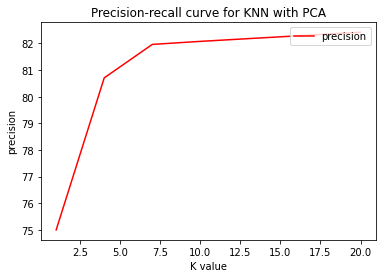

In [6]:
# same as pervious knn instead of rwo image, compressed image data will be used
# to see the time difference between
start_time = time.time()
kVals = [1, 4, 7, 10, 20]
accKNN_pca = []
for k in kVals:
    y_pred_knn = predictPD(X_train_pca, Y_train, X_test_pca, k)
    acc_KNN = evaluate(Y_test, y_pred_knn)
    accKNN_pca.append(acc_KNN)
    print("K = " + str(k) + "; Precision for KNN prediction: " + str(acc_KNN))
    
    print("\n--- {} seconds to run KNN by PCA with K reach to {}. ---\n".format((time.time() - start_time), k))
print("\n--- {} seconds to run KNN algorith with PCA and Partial distance meothod. ---\n".format((time.time() - start_time)))
if len(kVals) > 1:
    plt.plot(kVals, np.transpose(accKNN_pca), 'r', label = 'precision')
    plt.legend(loc = 'upper right')
    plt.xlabel('K value')
    plt.ylabel('precision')
    plt.title("Precision-recall curve for KNN with PCA")

# Prepare data for Bayes algorithms and Define Algorithms

In [ ]:
# flatten each image array from two dimension to one row
Xx = np.zeros((len(X_train), X_train[0].shape[0] * X_train[0].shape[1]))
for i in range(len(X_train)):
    Xx[i] = X_train[i].flatten()
    
Xt = np.zeros((len(X_test), X_test[0].shape[0] * X_test[0].shape[1]))
for i in range(len(X_test)):
    Xt[i] = X_test[i].flatten()
    
Xx_pca = np.zeros((len(X_train_pca), X_train_pca[0].shape[0] * X_train_pca[0].shape[1]))
for i in range(len(X_train_pca)):
    Xx_pca[i] = X_train_pca[i].flatten()
    
Xt_pca = np.zeros((len(X_test_pca), X_test_pca[0].shape[0] * X_test_pca[0].shape[1]))
for i in range(len(X_test_pca)):
    Xt_pca[i] = X_test_pca[i].flatten()

# Bayes algorithm based on Guassian model

In [18]:
class BayesGaussian:
    def __init__(self):
        self.fit_data = dict()
        self.category_num = 0
        self.train_data = np.mat([])
        self.train_label = np.mat([])
        self.test_data = np.mat([])
        self.predict_label = np.mat([])
        self.test_categories = []

    def gaussian_fit(self, category_i):
        indexes = [i for i, label in enumerate(self.train_label) if label == category_i]
        class_i_images = []
        for i in indexes:
            class_i_images.append(self.train_data[i])
        i_images_matrix = np.array(class_i_images)
        class_i_mean = i_images_matrix.mean(0)
        class_i_cov = np.cov(i_images_matrix, rowvar=0)
        self.fit_data[f"mean{category_i}"] = class_i_mean
        self.fit_data[f"cov{category_i}"] = class_i_cov

    def fit(self, input_train, input_label):
        start_time = time.time()
        self.train_data = input_train
        self.train_label = input_label
        self.category_num = max(input_label)
        for i in range(self.category_num + 1):
            self.gaussian_fit(i)

    def gaussian_predict(self, test_data):
        start_time = time.time()
        self.test_data = test_data
        for test_sample in self.test_data:
            category_possibilities = []
            for i in range(self.category_num):
                try:
                    i_possibility = multivariate_normal.pdf(test_sample, mean=self.fit_data[f"mean{i}"],
                                                            cov=self.fit_data[f"cov{i}"])
                    category_possibilities.append(i_possibility)
                except Exception:
                    pass
            try:
                self.test_categories.append(np.argmax(category_possibilities))
            except Exception:
                pass
        return self.test_categories

# Naive Bayes class 

In [19]:
class NaiveBayes:
    def fit(self, Xx, y):
        # get the size of input dataset
        Xx = np.array(Xx)
        n_samples, n_features = Xx.shape
        # get unique clases which are buildings and explosions
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            # where y is equal to class that being used with c label
            X_c = Xx[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        #  for each sample in test sample apply perdiction
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []
        
        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)

        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator


In [ ]:
# apply Bayes Classifier to image dataset and record the time
start_time = time.time()
bg = BayesGaussian()
bg.fit(Xx_pca, Y_train)
predictions = bg.gaussian_predict(Xt_pca)


print("\n--- {} seconds to run Guassian Bayes classification. ---\n".format((time.time() - start_time)))
print("Guassian Bayes classification precision: ", evaluate(Y_test, predictions))

In [12]:
# apply naive Bayes Classifier to image dataset and record the time
start_time = time.time()
nb = NaiveBayes()
nb.fit(Xx, Y_train)
predictions = nb.predict(Xt)


print("\n--- {} seconds to run Naive Bayes classification. ---\n".format((time.time() - start_time)))
print("Naive Bayes classification precision: ", evaluate(Y_test, predictions))


--- 76.7658257484436 seconds to run Naive Bayes classification. ---

Naive Bayes classification precision:  45.20547945205479


# Apply SVM classification to image dataset

In [6]:
# defined model will be used in all raw images and feature data
models = (svm.SVC(kernel="rbf", gamma=0.1, C=0.1), svm.SVC(kernel="rbf", gamma=0.8, C=1),
          svm.SVC(kernel="rbf", gamma=0.5, C=5), svm.SVC(kernel="rbf", gamma=0.8, C=10),
          svm.SVC(kernel="rbf", gamma=0.1, C=100), svm.SVC(kernel="poly", degree=2),
          svm.SVC(kernel="poly", degree=3), svm.SVC(kernel="poly", degree=8),
          svm.SVC(kernel="poly", degree=10), svm.SVC(kernel="poly", degree=12),)

# two kernel RBF and polynomial used in SVM
# for polynonimal Degree of 1-50 used, higher degree avi=oides as there is only four classes
# Gamma is used in different ranges to see the action of single training example
# C function kept small as trades off correct classification of training examples 
# against maximization of the decision function’s margin not noticable.
# this will take significant time to run as thers is lots of image and algorithme need to accomadate itself

In [ ]:
# apply svm models on datasets
start_time = time.time()
for i in models:
    print("\n-->>>The training of the model is started, please wait for while as it may take few minutes to complete")
    i.fit(Xx, Y_train)
    print('The Model is trained well with the given images data')
    pred_svm = i.predict(Xt)

    print("\n--- {} seconds to run SVM classification with kernel of {} and parameters equal to: {}. ---\n".format((time.time() - start_time), i.kernel, i))
    print("precision for this SVM classification: ", evaluate(Y_test, pred_svm))

print("\n--- {} seconds to run all models of SVM classification. ---\n".format((time.time() - start_time)))


-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 971.6211521625519 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=0.1, gamma=0.1). ---

precision for this SVM classification:  80.47945205479452

-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 1964.98948264122 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=1, gamma=0.8). ---

precision for this SVM classification:  80.47945205479452

-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 2944.151960372925 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=5, gamma=0.5). ---

precision for this SVM class

#  Step 2

In [7]:
# in here we will read Gabor data and 225 grid feature data
# reding procedure is same as the images
X_Gabor = []
keyF = os.listdir(r"project-data\features\gabor46")
for i in keyF:
    pathGabor = os.path.join("project-data\\features\\gabor46\\", i)
    tmpF = np.loadtxt(pathGabor)
    for i in tmpF:
        X_Gabor.append(i[1:])

X_Grid = []
keyF = os.listdir(r"project-data\features\grid5x5")
for i in keyF:
    pathGrid = os.path.join("project-data\\features\\grid5x5\\", i)
    tmpF = np.loadtxt(pathGrid)
    for i in tmpF:
        X_Grid.append(i[1:])
        
# all dataset is divided in two fold as train and test data set
# for the sake of cross validation, together random shuffle wil be used
tempBld = list(zip(X_Gabor, X_Grid, Y))
random.shuffle(tempBld)
X_Gabor, X_Grid, Y = zip(*tempBld)
X_Gabor_train, X_Gabor_test = X_Gabor[:][:int(len(Y) * 0.75)], X_Gabor[:][int(len(Y) * 0.75):]
X_Grid_train, X_Grid_test = X_Grid[:][:int(len(Y) * 0.75)], X_Grid[:][int(len(Y) * 0.75):]
Y_train, Y_test = Y[:int(len(Y) * 0.75)], Y[int(len(Y) * 0.75):]

def evaluate(y_true, y_pred):
    return (sum(x == y for x, y in zip(y_true, y_pred)) / len(y_true)) * 100

# knn for Gabor Feature data

K = 1; Precision for KNN prediction with Gabor Data: 72.3744292237443

--- 63.32172250747681 seconds to run KNN for Gabor Data with K reach to 1. ---

K = 4; Precision for KNN prediction with Gabor Data: 79.5662100456621

--- 114.31811308860779 seconds to run KNN for Gabor Data with K reach to 4. ---

K = 7; Precision for KNN prediction with Gabor Data: 82.76255707762557

--- 165.55113887786865 seconds to run KNN for Gabor Data with K reach to 7. ---

K = 10; Precision for KNN prediction with Gabor Data: 83.10502283105022

--- 218.89079427719116 seconds to run KNN for Gabor Data with K reach to 10. ---

K = 20; Precision for KNN prediction with Gabor Data: 83.33333333333334

--- 268.5619885921478 seconds to run KNN for Gabor Data with K reach to 20. ---



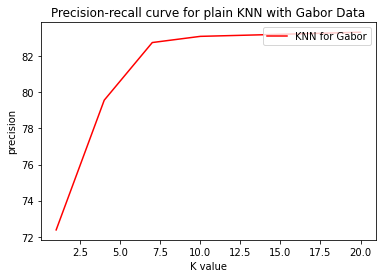

In [15]:
start_time = time.time()
kVals = [1, 4, 7, 10, 20]
accKNN = []
for k in kVals:
    y_pred_knn = predict(X_Gabor_train, Y_train, X_Gabor_test, k)
    acc_KNN = evaluate(Y_test, y_pred_knn)
    accKNN.append(acc_KNN)
    print("K = " + str(k) + "; Precision for KNN prediction with Gabor Data: " + str(acc_KNN))
    
    print("\n--- {} seconds to run KNN for Gabor Data with K reach to {}. ---\n".format((time.time() - start_time), k))

if len(kVals) > 1:
    plt.plot(kVals, np.transpose(accKNN), 'r', label = 'KNN for Gabor')
    plt.legend(loc = 'upper right')
    plt.xlabel('K value')
    plt.ylabel('precision')
    plt.title("Precision-recall curve for plain KNN with Gabor Data")

# knn for Grid color Feature data

K = 1; Precision for KNN prediction with Grid Data: 71.23287671232876

--- 63.59795308113098 seconds to run KNN for Grid Data with K reach to 1. ---

K = 4; Precision for KNN prediction with Grid Data: 79.7945205479452

--- 121.72301936149597 seconds to run KNN for Grid Data with K reach to 4. ---

K = 7; Precision for KNN prediction with Grid Data: 83.10502283105022

--- 181.17206692695618 seconds to run KNN for Grid Data with K reach to 7. ---

K = 10; Precision for KNN prediction with Grid Data: 83.33333333333334

--- 239.42373180389404 seconds to run KNN for Grid Data with K reach to 10. ---

K = 20; Precision for KNN prediction with Grid Data: 83.33333333333334

--- 298.5806043148041 seconds to run KNN for Grid Data with K reach to 20. ---



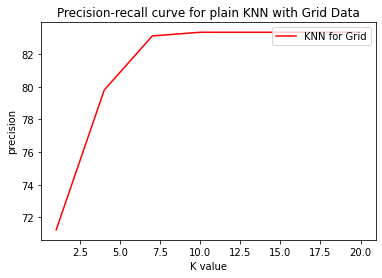

In [16]:
start_time = time.time()
kVals = [1, 4, 7, 10, 20]
accKNN = []
for k in kVals:
    y_pred_knn = predict(X_Grid_train, Y_train, X_Grid_test, k)
    acc_KNN = evaluate(Y_test, y_pred_knn)
    accKNN.append(acc_KNN)
    print("K = " + str(k) + "; Precision for KNN prediction with Grid Data: " + str(acc_KNN))
    
    print("\n--- {} seconds to run KNN for Grid Data with K reach to {}. ---\n".format((time.time() - start_time), k))

if len(kVals) > 1:
    plt.plot(kVals, np.transpose(accKNN), 'r', label = 'KNN for Grid')
    plt.legend(loc = 'upper right')
    plt.xlabel('K value')
    plt.ylabel('precision')
    plt.title("Precision-recall curve for plain KNN with Grid Data")

# Bayes for Gabor texture data

In [20]:
# aply Bayes Classifier to image dataset and record the time
start_time = time.time()
bg = BayesGaussian()
bg.fit(X_Gabor_train, Y_train)
predictions = bg.gaussian_predict(X_Gabor_test)


print("\n--- {} seconds to run Guassian Bayes classification. ---\n".format((time.time() - start_time)))
print("Guassian Bayes classification precision for Gabor: ", evaluate(Y_test, predictions))


--- 4.938791513442993 seconds to run Guassian Bayes classification. ---

Guassian Bayes classification precision for Gabor:  44.40639269406393


# Naive Bayes for Gabor texture data

In [21]:
start_time = time.time()
nb = NaiveBayes()
nb.fit(X_Gabor_train, Y_train)
predictions = nb.predict(X_Gabor_test)


print("\n--- {} seconds to run Naive Bayes classification. ---\n".format((time.time() - start_time)))
print("Naive Bayes classification precision for Gabor: ", evaluate(Y_test, predictions))


--- 0.37802863121032715 seconds to run Naive Bayes classification. ---

Naive Bayes classification precision for Gabor:  62.78538812785388


# Bayes for Grid color data

In [22]:
# aply Bayes Classifier to image dataset and record the time
start_time = time.time()
bg = BayesGaussian()
bg.fit(X_Grid_train, Y_train)
predictions = bg.gaussian_predict(X_Grid_test)


print("\n--- {} seconds to run Guassian Bayes classification. ---\n".format((time.time() - start_time)))
print("Guassian Bayes classification precision for Grid: ", evaluate(Y_test, predictions))


--- 30.819297790527344 seconds to run Guassian Bayes classification. ---

Guassian Bayes classification precision for Grid:  78.88127853881278


# Naive Bayes for Grid color data

In [23]:
start_time = time.time()
nb = NaiveBayes()
nb.fit(X_Grid_train, Y_train)
predictions = nb.predict(X_Grid_test)


print("\n--- {} seconds to run Naive Bayes classification. ---\n".format((time.time() - start_time)))
print("Naive Bayes classification precision for Grid: ", evaluate(Y_test, predictions))


--- 0.484738826751709 seconds to run Naive Bayes classification. ---

Naive Bayes classification precision for Grid:  50.799086757990864


# SVM for Gabor Texture dataset

In [ ]:
# apply svm models on datasets
start_time = time.time()
for i in models:
    print("\n-->>>The training of the model is started, please wait for while as it may take few minutes to complete")
    i.fit(X_Gabor_train, Y_train)
    print('The Model is trained well with the given images data')
    pred_svm = i.predict(X_Gabor_test)

    print("\n--- {} seconds to run SVM classification with kernel of {} and parameters equal to: {}. ---\n".format((time.time() - start_time), i.kernel, i))
    print("precision for this SVM classification: ", evaluate(Y_test, pred_svm))

print("\n--- {} seconds to run all models of SVM classification. ---\n".format((time.time() - start_time)))


-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 2.5631425380706787 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=0.1, gamma=0.1). ---

precision for this SVM classification:  83.33333333333334

-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 7.341562986373901 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=1, gamma=0.8). ---

precision for this SVM classification:  83.33333333333334

-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 11.975172996520996 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=5, gamma=0.5). ---

precision for this SVM cl

# SVM with Grid feature color dataset

In [8]:
# apply svm models on datasets
start_time = time.time()
for i in models:
    print("\n-->>>The training of the model is started, please wait for while as it may take few minutes to complete")
    i.fit(X_Grid_train, Y_train)
    print('The Model is trained well with the given images data')
    pred_svm = i.predict(X_Grid_test)

    print("\n--- {} seconds to run SVM classification with kernel of {} and parameters equal to: {}. ---\n".format((time.time() - start_time), i.kernel, i))
    print("precision for this SVM classification: ", evaluate(Y_test, pred_svm))

print("\n--- {} seconds to run all models of SVM classification. ---\n".format((time.time() - start_time)))


-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 12.948669910430908 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=0.1, gamma=0.1). ---

precision for this SVM classification:  81.39269406392694

-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 25.706664085388184 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=1, gamma=0.8). ---

precision for this SVM classification:  81.39269406392694

-->>>The training of the model is started, please wait for while as it may take few minutes to complete
The Model is trained well with the given images data

--- 38.39525318145752 seconds to run SVM classification with kernel of rbf and parameters equal to: SVC(C=5, gamma=0.5). ---

precision for this SVM cl